In [1]:
import os
import json
import torch
torch.set_grad_enabled(False)
import numpy as np
from pprint import pprint
import sys
sys.path.append('../..')
from nebula.models.attention import TransformerEncoderModel, TransformerEncoderChunks
from nebula import PEDynamicFeatureExtractor
from nebula.preprocessing import JSONTokenizerNaive, JSONTokenizerBPE
from nebula.misc import get_path, clear_cuda_cache, set_random_seed
from nebula.constants import *
from bertviz import model_view, head_view
from collections import Counter

from copy import deepcopy
from tqdm import tqdm
DEVICE = "cpu" #"cuda"

import matplotlib.pyplot as plt

SCRIPT_PATH = get_path(type="notebook")
ROOT = os.path.join(SCRIPT_PATH, "..", "..")

In [3]:
# done three folds on that run
MODEL_IDX = 1

# BPE
datafolder = os.path.join(ROOT, r"evaluation\paper_sota\out_speakeasy\nebula_speakeasy_vocab_50000_seqlen_512")
model_folder = os.path.join(ROOT, r"evaluation\paper_sota\out_speakeasy\cv_nebula_limNone_r1763_t20\training_files")

# Whitespace
# datafolder = os.path.join(ROOT, r"evaluation\paper_ablation\out_tokenizer\nebula_whitespace_vocab_50000_seqlen_512")
# model_folder = os.path.join(ROOT, r"evaluation\paper_ablation\out_tokenizer\cv_whitespace_limNone_r1763_t5\training_files")

# LOADING OBJECTS
model_file = [x for x in os.listdir(model_folder) if x.endswith(".torch")][MODEL_IDX]
model_file_fullpath = os.path.join(model_folder, model_file)
state_dict = torch.load(model_file_fullpath)
state_dict = torch.load(model_file_fullpath)

with open(os.path.join(datafolder, f"tokenizer_50000_vocab.json")) as f:
    nebula_vocab = json.load(f)

# BPE
tokenizer = JSONTokenizerBPE(
    vocab_size=len(nebula_vocab),
    seq_len=512,
    model_path=os.path.join(ROOT, datafolder, r"tokenizer_50000.model")
)

# Whitespace
# tokenizer = JSONTokenizerNaive(
#     vocab_size=len(nebula_vocab),
#     seq_len=512,
#     vocab=nebula_vocab
# )

model_config = {
        "vocab_size": len(nebula_vocab),
        "maxlen": 512,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }
model = TransformerEncoderChunks(**model_config)
model.load_state_dict(state_dict)
_ = model.to(DEVICE)


MODEL_CONFIG = model_config
TOKENIZER = tokenizer
STATE_DICT = state_dict
def get_score(example, title="this sample"):
    random_seed = 1492
    set_random_seed(random_seed)
    model = TransformerEncoderChunks(**MODEL_CONFIG).to(DEVICE)
    model.load_state_dict(STATE_DICT)
    model.eval()
    extractor = PEDynamicFeatureExtractor()
    exampleProcessed = extractor.filter_and_normalize_report(example)

    exampleTokenized = TOKENIZER.tokenize(exampleProcessed)
    if len(exampleTokenized) == 1:
        exampleTokenized = exampleTokenized[0]
    exampleEncoded = TOKENIZER.encode(exampleProcessed)
    x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)

    logit_bad = model(x[:, :512]).cpu()
    prob_bad = torch.sigmoid(logit_bad)
    print(f"  [!] Model scores on {title:>20} -- logit: {logit_bad[0][0].numpy():^8.4f} and probability: {prob_bad[0][0].numpy():.4f}")
    return logit_bad.numpy()[0][0]



In [4]:
def get_attn(x, model):
    attentions = []
    x = model.pos_encoder(model.encoder(x))
    for layer in model.transformer_encoder.layers:
        this_layer_attn = layer.self_attn(x,x,x, average_attn_weights=False)[1]
        attentions.append(this_layer_attn.cpu())
        x = layer(x)
    return attentions

def viz(start, end, attentions, exampleTokenized, threshold=0.005, layer=1, heads=[]):
    m = 1/threshold
    tokens = exampleTokenized[start:end]
    att_crop = [x[:, :, start:end, start:end]*m for x in attentions]
    head_view(att_crop, tokens, prettify_tokens=False, heads=heads, layer=layer)

def report_where_attends(seq_1, seq_2, token_location, tokenized_input):
    # TODO: somewhat broken?
    msg = ""
    token = tokenized_input[token_location]
    where_attends_seq_2 = np.where(seq_1 == token_location)[0]
    if len(where_attends_seq_2) > 0:
        counterpart_tokens = list(set([tokenized_input[x] for x in seq_2[where_attends_seq_2].tolist()]))
        if token in counterpart_tokens:
            counterpart_tokens.remove(token)
        if counterpart_tokens: # TODO: this part reports wrong results
            msg = f"\t  It has connections with tokens at following locations and values:\n"
            msg += f"\t\tLocated: {where_attends_seq_2}\n"
            msg += f"\t\tValues: {counterpart_tokens}\n"
    return msg

def analyze_attentions(attentions, tokenized_input, threshold=0.005, diff=20, most_common=5, types=["proximity", "frequency"], limit=20, verbose=True):
    counter = 0
    print(f"\n[!] Analyzing attentions based on {types}... ")
    for layer_nr, layer in enumerate(attentions):
        idxs = np.where(layer > threshold)
        print(f"\n[!] Total {len(idxs[0])} tokens has strong activations at layer {layer_nr} with threshold: {threshold}!")
        if len(idxs[0]) > 0:
            heads = idxs[1].tolist()
            attn_seq_1 = idxs[2]
            attn_seq_2 = idxs[3]

            if "proximity" in types:
                # PROXIMITY CHECK
                print(f"[*] Performing a token attention proximity check with token difference: {diff}... ")
                for j, (a1, a2) in enumerate(zip(attn_seq_1, attn_seq_2)):
                    # check if difference between a1 and a2 is below threshold
                    token_at_a1 = tokenized_input[a1]
                    token_at_a2 = tokenized_input[a2]  
                    if abs(a1 - a2) > diff:
                        if verbose:
                            print(f"\tThese two tokens has strong activations but are far (diff: {abs(a1 - a2)}):\n\t\t{token_at_a1}\n\t\t{token_at_a2}")
                    elif abs(a1 - a2) <= diff:
                        counter += 1
                        if counter > limit:
                            return
                        which_heads = heads[j]
                        print("\tThese two close sequence tokens has strong activations:", a1, a2, f"at layer {layer_nr} head", which_heads)
                        print(f"\t\tToken at location {a1} -> {token_at_a1}")
                        print(f"\t\tToken at location {a2} -> {token_at_a2}")
                        aa = sorted([a1, a2])
                        a1, a2 = aa[0]-5, aa[1]+5
                        if a1 < 0:
                            a1 = 0
                        if a2 > len(tokenized_input):
                            a2 = len(tokenized_input)
                        vizString = f"viz({a1}, {a2}, attentions, tokenized_input, layer={layer_nr}, heads=[{which_heads}])"
                        print("Calling:", vizString)
                        viz(a1, a2, attentions, tokenized_input, layer=layer_nr, heads=[which_heads])
            if "count" in types or "frequency" in types:
                # COUNTER CHECK
                print("[*] Performing a token frequency check ... ")
                c = attn_seq_2.tolist()
                c.extend((attn_seq_1.tolist()))
                c = Counter(c).most_common(most_common)        
                for token_location, token_frequency in c:
                    appear_in_heads = [heads[i] for i in np.where(attn_seq_1 == token_location)[0].tolist()]
                    appear_in_heads.extend([heads[i] for i in np.where(attn_seq_2 == token_location)[0].tolist()])
                    appear_in_heads = list(set(appear_in_heads))

                    token_value = tokenized_input[token_location]
                    msg1 = report_where_attends(attn_seq_1, attn_seq_2, token_location, tokenized_input)
                    msg2 = report_where_attends(attn_seq_2, attn_seq_2, token_location, tokenized_input)
                    if msg1 or msg2:
                        msg = f"\n\t> Token '{token_value}' location in sequence: {token_location}\n"
                        msg += f"\t  It appears {token_frequency} times, in layer {layer_nr}, heads: {appear_in_heads}\n"
                        msg += msg1 + msg2
                        print(msg)
                        
                        counter += 1
                        if counter > limit:
                            return

def get_attention_report(exampleFile, model, tokenizer, maxLen=512, random_seed=42, diff=20, threshold=0.004, limit=20, verbose=True):
    if isinstance(exampleFile, str) and os.path.exists(exampleFile):        
        with open(exampleFile) as f:
            example = json.load(f)
    elif isinstance(exampleFile, (dict, list)):
        example = exampleFile
    else:
        raise FileNotFoundError

    extractor = PEDynamicFeatureExtractor()
    exampleProcessed = extractor.filter_and_normalize_report(example[0])
    
    exampleTokenized = tokenizer.tokenize(exampleProcessed)
    if len(exampleTokenized) == 1:
        exampleTokenized = exampleTokenized[0]
    exampleEncoded = tokenizer.encode(exampleProcessed)
    x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)

    logit_bad = model(x[:, :maxLen]).cpu()
    prob_bad = torch.sigmoid(logit_bad)
    print("[!] Model scores on this sample -- logit:", logit_bad[0][0].numpy(), " and probability:", prob_bad[0][0].numpy())

    clear_cuda_cache()
    set_random_seed(random_seed)
    attentions = get_attn(x, model)
    analyze_attentions(attentions, exampleTokenized, types=["proximity"], threshold=threshold, diff=diff, limit=limit, verbose=verbose)
    analyze_attentions(attentions, exampleTokenized, types=["frequency"], most_common=10, limit=limit, threshold=threshold)
    return attentions, exampleTokenized

In [5]:
report_root = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_backdoor")
exampleFile = os.path.join(report_root, "0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json")
with open(exampleFile) as f:
    exampleFile = json.load(f)

# https://www.virustotal.com/gui/file/0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a
attentions, tokenized_input = get_attention_report(exampleFile, model, tokenizer, maxLen=512, random_seed=1492, diff=15, threshold=0.0025, limit=2, verbose=False)

[!] Model scores on this sample -- logit: 40.435215  and probability: 1.0

[!] Analyzing attentions based on ['proximity']... 

[!] Total 856409 tokens has strong activations at layer 0 with threshold: 0.0025!
[*] Performing a token attention proximity check with token difference: 15... 
	These two close sequence tokens has strong activations: 0 0 at layer 0 head 0
		Token at location 0 -> ▁fileaccess
		Token at location 0 -> ▁fileaccess
Calling: viz(0, 5, attentions, tokenized_input, layer=0, heads=[0])


<IPython.core.display.Javascript object>

	These two close sequence tokens has strong activations: 0 1 at layer 0 head 0
		Token at location 0 -> ▁fileaccess
		Token at location 1 -> ▁event
Calling: viz(0, 6, attentions, tokenized_input, layer=0, heads=[0])


<IPython.core.display.Javascript object>


[!] Analyzing attentions based on ['frequency']... 

[!] Total 856409 tokens has strong activations at layer 0 with threshold: 0.0025!
[*] Performing a token frequency check ... 

	> Token '▁kernel32' location in sequence: 432
	  It appears 4918 times, in layer 0, heads: [0, 1, 2, 3, 4, 5, 6, 7]
	  It has connections with tokens at following locations and values:
		Located: [ 97486  97487  97488 ... 841714 841715 841716]
		Values: ['▁0x414253', 'getsystemtimeasfiletime', '▁0xfeee0004', '▁write', 'windows', '▁0x1211fd8', '▁0x4244d0', 'set', 'tlssetvalue', '▁0x424518', 'getcurrentprocessid', '▁0xfeee0002', 'olf', '▁0x414254', 'encodepointer', 'ret', 'dex', '▁0x424458', 'sh', '▁0x1211fd0', '▁fileaccess', 'in', 'ss', 'info', 'getprocaddress', '▁0x424548', 'heapcreate', '▁0x424530', '▁0x4244a0', '▁read', '▁0x424560', 'drive', '▁0x4244e8', '▁0xfeee0003', '▁path', '▁0x4244b8', '15c', '▁0xfa0', '▁0x1', 'g', 'args', '▁0x424500', '▁flsfree', '▁0x1211f7c', 'window', 'e', 'initializecriticalsecti

# Adversarial examples

In [41]:
report_root = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_backdoor")
exampleFile = os.path.join(report_root, "0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json")
print(exampleFile)
with open(exampleFile) as f:
    exampleFile = json.load(f)

C:\Users\dtrizna\Code\nebula\evaluation\adversarial\..\..\data\data_raw\windows_emulation_trainset\report_backdoor\0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json


In [42]:
get_score(exampleFile)

  [!] Model scores on          this sample -- logit: 75.9193  and probability: 1.0000


75.91932

## Adding legitimate APIs at the beginning

### Single legitimate API

#### Once

In [8]:
legit_api = {
                "pc": "0x4015f0",
                "api_name": "msvcrt.memset",
                "args": [
                    "0x1211d8c",
                    "0x0",
                    "0x1fc"
                ],
                "ret_val": "0x1211d8c"
            }

orig_apis = deepcopy(exampleFile[0]['apis'])
adversarial_example = deepcopy(exampleFile)
adversarial_example[0]['apis'] = [legit_api] + orig_apis
print(f"  [!] Len orig apis: {len(orig_apis)} and len adversarial apis: {len(adversarial_example[0]['apis'])}")
_ = get_score(adversarial_example)


  [!] Len orig apis: 490 and len adversarial apis: 491
  [!] Model scores on          this sample -- logit: 70.6631  and probability: 1.0000


#### Increasing loop

In [9]:
legit_api = {
                "pc": "0x4015f0",
                "api_name": "msvcrt.memset",
                "args": [
                    "0x1211d8c",
                    "0x0",
                    "0x1fc"
                ],
                "ret_val": "0x1211d8c"
            }

logits_api = []
for i in range(0, 20, 1):
    print(f"  [!] Iteration {i}")
    orig_apis = deepcopy(exampleFile[0]['apis'])
    adversarial_example = deepcopy(exampleFile)
    adversarial_example[0]['apis'] = i*[legit_api] + orig_apis
    print(f"  [!] Len orig apis: {len(orig_apis)} and len adversarial apis: {len(adversarial_example[0]['apis'])}")
    l = get_score(adversarial_example)
    logits_api.append(l)

  [!] Iteration 0
  [!] Len orig apis: 490 and len adversarial apis: 490
  [!] Model scores on          this sample -- logit: 75.9193  and probability: 1.0000
  [!] Iteration 1
  [!] Len orig apis: 490 and len adversarial apis: 491
  [!] Model scores on          this sample -- logit: 70.6631  and probability: 1.0000
  [!] Iteration 2
  [!] Len orig apis: 490 and len adversarial apis: 492
  [!] Model scores on          this sample -- logit: 64.2084  and probability: 1.0000
  [!] Iteration 3
  [!] Len orig apis: 490 and len adversarial apis: 493
  [!] Model scores on          this sample -- logit: 63.3084  and probability: 1.0000
  [!] Iteration 4
  [!] Len orig apis: 490 and len adversarial apis: 494
  [!] Model scores on          this sample -- logit: 66.3087  and probability: 1.0000
  [!] Iteration 5
  [!] Len orig apis: 490 and len adversarial apis: 495
  [!] Model scores on          this sample -- logit: 69.4387  and probability: 1.0000
  [!] Iteration 6
  [!] Len orig apis: 490 and

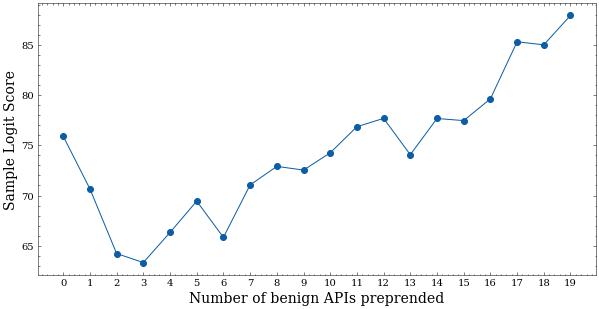

In [10]:
import scienceplots
plt.style.use(['science', 'no-latex'])

logits = np.array(logits_api)
# plot 
plt.figure(figsize=(10,5))
plt.plot(logits)
plt.scatter(range(0,20), logits)
plt.ylabel("Sample Logit Score", fontsize=14)
plt.xlabel("Number of benign APIs preprended", fontsize=14)
# set xlabelticks from 0 to 20 with step 1
_ = plt.xticks(np.arange(0, 20, 1))

### Pre-pending legitimate APIs from benign samples

In [11]:
benign_folder = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_windows_syswow64")

from collections import defaultdict
logits = defaultdict(list)
for file in os.listdir(benign_folder)[:30]:
    print("\n[*] Starting with file:", file, "...")
    if not file.endswith("json"):
        continue
    with open(os.path.join(benign_folder, file)) as f:
        benign = json.load(f)

    for i in [1, 2, 4, 8, 16]:
        print(f" Multiplier: {i}")
        legit_apis = deepcopy(benign[0]['apis'])
        orig_apis = deepcopy(exampleFile[0]['apis'])
        adversarial_example = deepcopy(exampleFile)
        adversarial_example[0]['apis'] = i*legit_apis + orig_apis
        print(f"  [!] Len orig apis: {len(orig_apis)} and len adversarial apis: {len(adversarial_example[0]['apis'])}")

        l = get_score(adversarial_example)
        logits[i].append(l)


[*] Starting with file: agentactivationruntimestarter.json ...
 Multiplier: 1
  [!] Len orig apis: 490 and len adversarial apis: 495
  [!] Model scores on          this sample -- logit: 67.6285  and probability: 1.0000
 Multiplier: 2
  [!] Len orig apis: 490 and len adversarial apis: 500
  [!] Model scores on          this sample -- logit: 71.3066  and probability: 1.0000
 Multiplier: 4
  [!] Len orig apis: 490 and len adversarial apis: 510
  [!] Model scores on          this sample -- logit: 69.8146  and probability: 1.0000
 Multiplier: 8
  [!] Len orig apis: 490 and len adversarial apis: 530
  [!] Model scores on          this sample -- logit: 70.1237  and probability: 1.0000
 Multiplier: 16
  [!] Len orig apis: 490 and len adversarial apis: 570
  [!] Model scores on          this sample -- logit: 70.1237  and probability: 1.0000

[*] Starting with file: appidtel.json ...
 Multiplier: 1
  [!] Len orig apis: 490 and len adversarial apis: 503
  [!] Model scores on          this sample

(-0.5, 10.0)

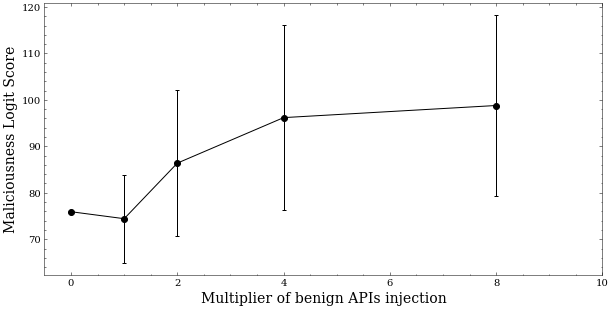

In [34]:
logits[0] = [75.9193]
try:
    del logits[16]
except:
    pass
x = sorted(list(logits.keys()))
y = [np.mean(logits[k]) for k in x]
yerr = [np.std(logits[k]) for k in x]
plt.figure(figsize=(10,5))
# add errorbars with borders
plt.errorbar(x, y, yerr=yerr, fmt='o', capthick=1, capsize=2, color="black")
# add line with the same color as above
plt.plot(x, y, color='black')
plt.xlabel("Multiplier of benign APIs injection", fontsize=14)
plt.ylabel("Maliciousness Logit Score", fontsize=14)
# xticks and xlabels 1,2,4,8,16
# _ = plt.xticks([1,2,4,8,16], [1,2,4,8,16])
plt.xlim(-0.5, 10)
# plt.xscale('log')

## File access modifications

### Original score

In [ ]:
report_root = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_backdoor")
exampleFile = os.path.join(report_root, "0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json")

with open(exampleFile) as f:
    exampleFile = json.load(f)

random_seed = 1492
set_random_seed(random_seed)
model = TransformerEncoderChunks(**MODEL_CONFIG).to(DEVICE)
model.load_state_dict(STATE_DICT)
model.eval()
extractor = PEDynamicFeatureExtractor()
exampleProcessed = extractor.filter_and_normalize_report(exampleFile)

exampleTokenized = TOKENIZER.tokenize(exampleProcessed)
if len(exampleTokenized) == 1:
    exampleTokenized = exampleTokenized[0]
exampleEncoded = TOKENIZER.encode(exampleProcessed)
x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)

logit_bad = model(x[:, :512]).cpu()
prob_bad = torch.sigmoid(logit_bad)
print(f"  [!] Model scores -- logit: {logit_bad[0][0].numpy():^8.4f} and probability: {prob_bad[0][0].numpy():.4f}")


### Remove any file modifications

In [45]:
adversarial_example = deepcopy(exampleFile)
adversarial_example[0]["file_access"] = []

random_seed = 1492
set_random_seed(random_seed)
model = TransformerEncoderChunks(**model_config).to(DEVICE)
model.load_state_dict(state_dict)
model.eval()
extractor = PEDynamicFeatureExtractor()
exampleProcessed = extractor.filter_and_normalize_report(adversarial_example)

exampleTokenized = tokenizer.tokenize(exampleProcessed)
if len(exampleTokenized) == 1:
    exampleTokenized = exampleTokenized[0]
exampleEncoded = tokenizer.encode(exampleProcessed)
x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)

logit_bad = model(x[:, :512]).cpu()
prob_bad = torch.sigmoid(logit_bad)
print("  [ ] Model scores on this sample -- logit:", logit_bad[0][0].numpy(), " and probability:", prob_bad[0][0].numpy())


  [ ] Model scores on this sample -- logit: -2.1924105  and probability: 0.1004341


### Inject legitimate file activities

In [36]:
from pprint import pprint
benign_folder = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_clean")
# cd /mnt/c/Users/dtrizna/Code/nebula/data/data_raw/windows_emulation_trainset/report_clean
# grep -rn . -ie "file_ac"
file_examples = ["0004c0ff7776dea5d0297fe8097813c98da7c490c7e6ddb60214c067777621b2.json", 
                 "0008ac09c36a9d430ed9639165a0dcd714878573bed032548246bb5d77b63eff.json",
                 "./000c81a10306c4ecaf17ad7a56543a555de0c2b1b51c6ef64927a1da34676b9a.json",
                 "./0029db52469940e64c9755dd7b5794e889ea54dc9a59dd01d663f59ef4087523.json"]

for example in file_examples:
    with open(os.path.join(benign_folder, example)) as f:
        benign = json.load(f)
    
    print("\n[!] Injecting this sample's file manipulations:")
    print("\t", benign[0]['file_access'])

    adversarial_example = deepcopy(exampleFile)
    orig_file_access = deepcopy(adversarial_example[0]["file_access"])
    adversarial_example[0]["file_access"] = deepcopy(benign[0]['file_access']) + orig_file_access

    random_seed = 1492
    set_random_seed(random_seed)
    model = TransformerEncoderChunks(**model_config).to(DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    extractor = PEDynamicFeatureExtractor()
    exampleProcessed = extractor.filter_and_normalize_report(adversarial_example)

    exampleTokenized = tokenizer.tokenize(exampleProcessed)
    if len(exampleTokenized) == 1:
        exampleTokenized = exampleTokenized[0]
    exampleEncoded = tokenizer.encode(exampleProcessed)
    x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)

    logit_bad = model(x[:, :512]).cpu()
    prob_bad = torch.sigmoid(logit_bad)
    
    print("  [>] Model scores on this sample -- logit:", logit_bad[0][0].numpy(), " and probability:", prob_bad[0][0].numpy())



[!] Injecting this sample's file manipulations:
	 [{'event': 'open', 'path': 'C:\\Windows\\system32\\0004c0ff7776dea5d0297fe8097813c98da7c490c7e6ddb60214c067777621b2', 'open_flags': ['OPEN_EXISTING']}]
  [>] Model scores on this sample -- logit: 72.498764  and probability: 1.0

[!] Injecting this sample's file manipulations:
	 [{'event': 'open', 'path': 'C:\\Windows\\system32\\0008ac09c36a9d430ed9639165a0dcd714878573bed032548246bb5d77b63eff', 'open_flags': ['OPEN_EXISTING'], 'access_flags': ['GENERIC_READ']}, {'event': 'read', 'path': 'C:\\Windows\\system32\\0008ac09c36a9d430ed9639165a0dcd714878573bed032548246bb5d77b63eff', 'size': 1542, 'buffer': '0x1210a34'}]
  [>] Model scores on this sample -- logit: 74.30382  and probability: 1.0

[!] Injecting this sample's file manipulations:
	 [{'event': 'create', 'path': '㩃停潲牧浡䘠汩獥\\GUT_1646332290.tmp', 'open_flags': ['OPEN_ALWAYS'], 'access_flags': ['GENERIC_READ', 'GENERIC_WRITE']}]
  [>] Model scores on this sample -- logit: 72.744736  and 

### Change filename to some legitimately looking

From `C:\\Windows\\temp\\golfini.ini` to `C:\\Windows\\temp\\mssvc.ini`

In [ ]:
report_root = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_backdoor")
exampleFile = os.path.join(report_root, "0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json")
with open(exampleFile) as f:
    exampleFile = json.load(f)

adversarial_example = deepcopy(exampleFile)

for i, access in enumerate(adversarial_example[0]["file_access"]):
    path = access['path']
    # get only filename
    filename = os.path.basename(path)
    # replace filename with mssvc.ini
    path = path.replace(filename, "mssvc.ini")
    
    access['path'] = path
    adversarial_example[0]["file_access"][i] = access

random_seed = 1492
set_random_seed(random_seed)
model = TransformerEncoderChunks(**model_config).to(DEVICE)
model.load_state_dict(state_dict)
model.eval()
extractor = PEDynamicFeatureExtractor()
exampleProcessed = extractor.filter_and_normalize_report(adversarial_example)

exampleTokenized = tokenizer.tokenize(exampleProcessed)
if len(exampleTokenized) == 1:
    exampleTokenized = exampleTokenized[0]
exampleEncoded = tokenizer.encode(exampleProcessed)
x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)

logit_bad = model(x[:, :512]).cpu()
prob_bad = torch.sigmoid(logit_bad)
print("  [ ] Model scores on this sample -- logit:", logit_bad[0][0].numpy(), " and probability:", prob_bad[0][0].numpy())


  [ ] Model scores on this sample -- logit: 75.8184  and probability: 1.0


### The same, although not changing filename, but filepath:

In [ ]:
report_root = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_backdoor")
exampleFile = os.path.join(report_root, "0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json")
with open(exampleFile) as f:
    exampleFile = json.load(f)

adversarial_example = deepcopy(exampleFile)

for i, access in enumerate(adversarial_example[0]["file_access"]):
    path = access['path']
    # get only base filepath
    dirname = os.path.dirname(path)
    # replace filename with mssvc.ini
    print("\n\t Old path: ", path)
    path = path.replace(dirname, "C:\\User\\user\\AppData\\Temp")
    print("\t New path: ", path)

    access['path'] = path
    adversarial_example[0]["file_access"][i] = access

random_seed = 1492
set_random_seed(random_seed)
model = TransformerEncoderChunks(**model_config).to(DEVICE)
model.load_state_dict(state_dict)
model.eval()
extractor = PEDynamicFeatureExtractor()
exampleProcessed = extractor.filter_and_normalize_report(adversarial_example)

exampleTokenized = tokenizer.tokenize(exampleProcessed)
if len(exampleTokenized) == 1:
    exampleTokenized = exampleTokenized[0]
exampleEncoded = tokenizer.encode(exampleProcessed)
x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)

logit_bad = model(x[:, :512]).cpu()
prob_bad = torch.sigmoid(logit_bad)
print("  [ ] Model scores on this sample -- logit:", logit_bad[0][0].numpy(), " and probability:", prob_bad[0][0].numpy())



	 Old path:  C:\Windows\temp\golfinfo.ini
	 New path:  C:\User\user\AppData\Temp\golfinfo.ini

	 Old path:  C:\Windows\temp\golfset.ini
	 New path:  C:\User\user\AppData\Temp\golfset.ini

	 Old path:  C:\Windows\temp\golfinfo.ini
	 New path:  C:\User\user\AppData\Temp\golfinfo.ini

	 Old path:  C:\Windows\temp\golfinfo.ini
	 New path:  C:\User\user\AppData\Temp\golfinfo.ini

	 Old path:  C:\Windows\system32\0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a
	 New path:  C:\User\user\AppData\Temp\0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a

	 Old path:  C:\Windows\system32\0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a
	 New path:  C:\User\user\AppData\Temp\0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a

	 Old path:  Cd.exedows\temp\HGDraw.dll
	 New path:  C:\User\user\AppData\Temp\HGDraw.dll

	 Old path:  Cd.exedows\temp\HGDraw.dll
	 New path:  C:\User\user\AppData\Temp\HGDraw.dll
  [ ] Model scores on this sample 

### Change folder and filename, but not extension

In [ ]:
import random
report_root = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_backdoor")
exampleFile = os.path.join(report_root, "0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json")
with open(exampleFile) as f:
    exampleFile = json.load(f)

adversarial_example = deepcopy(exampleFile)

for i, access in enumerate(adversarial_example[0]["file_access"]):
    path = access['path']
    # get only base filepath
    dirname = os.path.dirname(path)
    filename = os.path.basename(path)
    
    print("\n\t Old path: ", path)
    # replace filepath
    path = path.replace(dirname, "C:\\User\\user\\AppData\\Google\\Temp")
    # replace filename, but keep extension the same
    if len(filename.split(".")) > 1:
        random_digits = str(random.randint(1000000000, 9999999999))
        path = path.replace(".".join(filename.split(".")[:-1]), f"GUT_{random_digits}")
    else:
        path = path.replace(filename, "GUT_1646350089.tmp")

    
    print("\t New path: ", path)

    access['path'] = path
    adversarial_example[0]["file_access"][i] = access

random_seed = 1492
set_random_seed(random_seed)
model = TransformerEncoderChunks(**model_config).to(DEVICE)
model.load_state_dict(state_dict)
model.eval()
extractor = PEDynamicFeatureExtractor()
exampleProcessed = extractor.filter_and_normalize_report(adversarial_example)

exampleTokenized = tokenizer.tokenize(exampleProcessed)
if len(exampleTokenized) == 1:
    exampleTokenized = exampleTokenized[0]
exampleEncoded = tokenizer.encode(exampleProcessed)
x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)

logit_bad = model(x[:, :512]).cpu()
prob_bad = torch.sigmoid(logit_bad)
print("\n  [ ] Model scores on this sample -- logit:", logit_bad[0][0].numpy(), " and probability:", prob_bad[0][0].numpy())



	 Old path:  C:\Windows\temp\golfinfo.ini
	 New path:  C:\User\user\AppData\Google\Temp\GUT_5874340920.ini

	 Old path:  C:\Windows\temp\golfset.ini
	 New path:  C:\User\user\AppData\Google\Temp\GUT_5362635507.ini

	 Old path:  C:\Windows\temp\golfinfo.ini
	 New path:  C:\User\user\AppData\Google\Temp\GUT_4864273179.ini

	 Old path:  C:\Windows\temp\golfinfo.ini
	 New path:  C:\User\user\AppData\Google\Temp\GUT_8377265524.ini

	 Old path:  C:\Windows\system32\0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a
	 New path:  C:\User\user\AppData\Google\Temp\GUT_1646350089.tmp

	 Old path:  C:\Windows\system32\0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a
	 New path:  C:\User\user\AppData\Google\Temp\GUT_1646350089.tmp

	 Old path:  Cd.exedows\temp\HGDraw.dll
	 New path:  C:\User\user\AppData\Google\Temp\GUT_6149899137.dll

	 Old path:  Cd.exedows\temp\HGDraw.dll
	 New path:  C:\User\user\AppData\Google\Temp\GUT_4602574620.dll

  [ ] Model scores on this s

### Avoid dropping DLLs

In [ ]:
report_root = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_backdoor")
exampleFile = os.path.join(report_root, "0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json")
with open(exampleFile) as f:
    exampleFile = json.load(f)

adversarial_example = deepcopy(exampleFile)

for i, access in enumerate(adversarial_example[0]["file_access"]):
    path = access['path']
    access['path'] = path
    adversarial_example[0]["file_access"][i] = access

random_seed = 1492
set_random_seed(random_seed)
model = TransformerEncoderChunks(**model_config).to(DEVICE)
model.load_state_dict(state_dict)
model.eval()
extractor = PEDynamicFeatureExtractor()
exampleProcessed = extractor.filter_and_normalize_report(adversarial_example)

exampleTokenized = tokenizer.tokenize(exampleProcessed)
if len(exampleTokenized) == 1:
    exampleTokenized = exampleTokenized[0]
exampleEncoded = tokenizer.encode(exampleProcessed)
x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)

logit_bad = model(x[:, :512]).cpu()
prob_bad = torch.sigmoid(logit_bad)
print("  [ ] Model scores on this sample -- logit:", logit_bad[0][0].numpy(), " and probability:", prob_bad[0][0].numpy())


  [ ] Model scores on this sample -- logit: 35.266155  and probability: 1.0


### Statistical analysis of file modifications

In [78]:
report_root = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_backdoor")

has_file_access = []
LIMIT = 500
for file in tqdm(os.listdir(report_root)[:LIMIT]):
    if not file.endswith(".json"):
        continue
    with open(os.path.join(report_root, file)) as f:
        file_raw = json.load(f)
    if [x for x in file_raw if "file_access" in x]:
        #print("[!] Found file_access in: ", file)
        has_file_access.append((os.path.join(report_root, file), file_raw))
    

100%|██████████| 500/500 [00:00<00:00, 537.70it/s]


In [79]:
len(has_file_access)

266

In [183]:
import random
import string
def change_folder(path, new_folder):
    # get only base filepath
    dirname = os.path.dirname(path)
    
    # replace filepath
    path = path.replace(dirname, "C:\\User\\user\\AppData\\Google\\Temp")
    # replace filename, but keep extension the same
    return path

def change_filename(path, new_filename):
    filename = os.path.basename(path)
    if len(filename.split(".")) > 1:
        # leave extension
        filename = ".".join(filename.split(".")[:-1])        
    path = path.replace(filename, new_filename)
    return path


results = defaultdict(list)
LIMIT = None
for file_name, file_content in has_file_access[0:LIMIT]:
    print('\n[!!!] Processing file: ', file_name)
    results['No modifications'].append(get_score(file_content))

    # change file directories to appdata/google and get score
    print("  [*] Running modificaitons with file folder change to Google's Temp...")
    adversarial_example = deepcopy(file_content)
    for entry in adversarial_example:
        if "file_access" in entry:
            for i, access in enumerate(entry["file_access"]):
                print(f"\t [{i}] Old path: ", access['path'])
                access['path'] = change_folder(access['path'], "C:\\User\\user\\AppData\\Google\\Temp")
                print(f"\t [{i}] New path: ", access['path'])
    results['changed_folder'].append(get_score(adversarial_example, "changed folder"))

    # change file name to legit
    print("  [*] Running modificaitons with filename change to legit one...")
    adversarial_example = deepcopy(file_content)
    for entry in adversarial_example:
        if "file_access" in entry:
            for i, access in enumerate(entry["file_access"]):
                print(f"\t [{i}] Old path: ", access['path'])
                access['path'] = change_filename(access['path'], "chrome")
                print(f"\t [{i}] New path: ", access['path'])
    results['changed_filename_(legit)'].append(get_score(adversarial_example, "changed filename"))

    # change filename to random
    print("  [*] Running modificaitons with filename change to random one...")
    adversarial_example = deepcopy(file_content)
    for entry in adversarial_example:
        if "file_access" in entry:
            for i, access in enumerate(entry["file_access"]):
                print(f"\t [{i}] Old path: ", access['path'])
                random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
                access['path'] = change_filename(access['path'], random_string)
                print(f"\t [{i}] New path: ", access['path'])
    results['changed_filename_(random)'].append(get_score(adversarial_example, "changed filename"))

    # remove all file modifications and get score
    adversarial_example = deepcopy(file_content)
    for entry in adversarial_example:
        if "file_access" in entry:
            entry["file_access"] = []
    results['file_access_avoided'].append(get_score(adversarial_example, "removed file_access"))



[!!!] Processing file:  C:\Users\dtrizna\Code\nebula\evaluation\adversarial\..\..\data\data_raw\windows_emulation_trainset\report_backdoor\0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json
  [!] Model scores on          this sample -- logit: 75.9193  and probability: 1.0000
  [*] Running modificaitons with file folder change to Google's Temp...
	 [0] Old path:  C:\Windows\temp\golfinfo.ini
	 [0] New path:  C:\User\user\AppData\Google\Temp\golfinfo.ini
	 [1] Old path:  C:\Windows\temp\golfset.ini
	 [1] New path:  C:\User\user\AppData\Google\Temp\golfset.ini
	 [2] Old path:  C:\Windows\temp\golfinfo.ini
	 [2] New path:  C:\User\user\AppData\Google\Temp\golfinfo.ini
	 [3] Old path:  C:\Windows\temp\golfinfo.ini
	 [3] New path:  C:\User\user\AppData\Google\Temp\golfinfo.ini
	 [4] Old path:  C:\Windows\system32\0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a
	 [4] New path:  C:\User\user\AppData\Google\Temp\0009064322cdc719a82317553b805cbbc64230a9212d3b

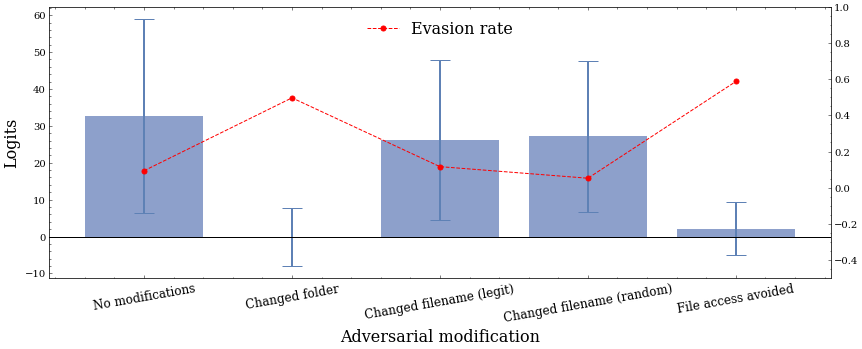

In [186]:
import scienceplots
plt.style.use(['science', 'no-latex'])

# logit results
x = results.keys()
y = {}
yerr = {}
for k in results.keys():
    y[k] = np.mean(results[k])
    yerr[k] = np.std(results[k])

def sigmoid(i):
    return 1 / (1 + np.exp(-i))

# barplot of results with caption on err bars and bars the same color as bars
plt.figure(figsize=(14,5))
# default mild blue color
x = [" ".join(v.split("_")).capitalize() for v in x]
color='#8da0cb'
# make ecolor darker
ecolor = '#5e81b5'
# plot barplot with bold error bars
plt.bar(x, y.values(), yerr=yerr.values(), capsize=10, ecolor=ecolor, color=color, error_kw={'elinewidth': 2})
# increase font of xticks and rotate by 45 degrees
plt.xticks(fontsize=12, rotation=10)
plt.xlabel("Adversarial modification", fontsize=16)
plt.ylabel("Logits", fontsize=16)
# plot line at 0 horizontal
plt.axhline(y=0, color='black', linewidth=1)


# evasion results
evasive = {}
for k in results:
    evasive[k] = 0
    for logit in results[k]:
        prob = sigmoid(logit)
        # ember threshold
        emb_threshold = 0.833
        if prob < emb_threshold:
            evasive[k] += 1
    evasive[k] = evasive[k] / len(results[k])

# add second y axis on the right and plot evasion results with dashed red line
ax2 = plt.gca().twinx()
ax2.plot(x, evasive.values(), color='red', linestyle='dashed', marker='.', markersize=10)
#ax2.set_ylabel("Evasion rate", fontsize=16)
ax2.set_ylim([-0.5,1])

plt.legend(["Evasion rate"], loc='upper center', fontsize=16)

plt.savefig("file_access_attacks.png", dpi=300, bbox_inches='tight')